# Loading Data

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from utils import horizontal, literal_evaluate
import plotly.express as px
import plotly.graph_objects as go
import plotly.colors as pc
from sklearn.linear_model import LinearRegression
plt.style.use("ggplot")

all_55000_steam = pd.read_csv("data/all_55000_steam.csv", low_memory=False)
# all_55000_steam = all_55000_steam.drop(['website', 'header_image'])

2024-10-21 11:47:51.326 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2024-10-21 11:47:51.329 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2024-10-21 11:47:51.330 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager


# Feature Engineering

In [3]:
def perform_feature_engineering():
    # Categorizing Price
    bins = [-1, 0, 10, 50, float('inf')]  # -1 to include 0 in the first bin
    labels = ['Free to Play', 'Under $10', '$10-50', 'Over $50']
    all_55000_steam['price_category'] = pd.cut(all_55000_steam['price'], bins=bins, labels=labels)

    # Creating a total review counts feature
    all_55000_steam['total_review_count'] = all_55000_steam['positive_reviews'] + all_55000_steam['negative_reviews']
    all_55000_steam['positive_ratio'] = all_55000_steam['positive_reviews'] / all_55000_steam['total_review_count']

    # Categorizing total review counts
    bins = [-1, 7, 15, 30, 60, 125, 250, 500, 1000, 2000, float('inf')]
    all_55000_steam['total_review_bins'] = pd.cut(all_55000_steam['total_review_count'], bins=bins)

    # Making "ownerss" a categorical ordinal feature
    owners_order = [
            "0 .. 20,000",
            "20,000 .. 50,000",
            "50,000 .. 100,000",
            "100,000 .. 200,000",
            "200,000 .. 500,000",
            "500,000 .. 1,000,000",
            "1,000,000 .. 2,000,000",
            "2,000,000 .. 5,000,000",
            "5,000,000 .. 10,000,000",
            "10,000,000 .. 20,000,000",
            "20,000,000 .. 50,000,000",
            "50,000,000 .. 100,000,000",
            "200,000,000 .. 500,000,000",  
        ]
    all_55000_steam['owners'] = pd.Categorical(all_55000_steam['owners'], categories=owners_order, ordered=True)

    # Converting missed datetime format "MON DD, YYYY"
    pattern_mon_day_year_comma = r'^[A-Za-z]{3} \d{1,2}, \d{4}$'  # Matches "Mon DD, YYYY" format
    mask_mon_day_year_comma = all_55000_steam['release_date'].str.match(pattern_mon_day_year_comma, na=False)
    all_55000_steam.loc[mask_mon_day_year_comma, 'release_date'] = pd.to_datetime(all_55000_steam.loc[mask_mon_day_year_comma, 'release_date'], format='%b %d, %Y')

    # Creating a new feature 'release_year' by binning on release_date
    all_55000_steam['release_date'] = pd.to_datetime(all_55000_steam['release_date'], format='%Y-%m-%d')
    all_55000_steam['release_year'] = all_55000_steam['release_date'].dt.year
    all_55000_steam['release_year'] = all_55000_steam['release_year'].astype("Int64")

    # Creating a revenue estimation using initial_price, price, and review counts
perform_feature_engineering()


# Basic Stats

In [4]:
horizontal([all_55000_steam.describe(), all_55000_steam[all_55000_steam.drop(['website', 'header_image'], axis=1).select_dtypes(include=['object', 'category']).columns].describe()])

In [62]:
# def plot_correlation_heatmap() -> plt.Figure:
#     fig = plt.figure()
#     sns.heatmap(
#         data=all_55000_steam.select_dtypes(include='number').drop('app_id', axis=1).corr(),
#         annot=True,
#         cmap='coolwarm',
#         vmax=1,
#         vmin=-1,
#         square=True
#     )
#     plt.title('Correlation heatmap of numeric features', y=1.01)
#     return fig
# fig = plot_correlation_heatmap()

# Remade with plotly
def plot_correlation_heatmap() -> go.Figure:
    corr_matrix = all_55000_steam.select_dtypes(include='number').drop('app_id', axis=1).corr()
    corr_matrix = np.round(corr_matrix, 2)

    fig = px.imshow(
        corr_matrix,
        text_auto=True, 
        color_continuous_scale='RdBu_r',
        zmin=-1,
        zmax=1,
        aspect="auto"
    )
    
    fig.update_layout(
        title='Correlation heatmap',
        width=700,
        height=700,
        margin=dict(l=120, r=120, t=100, b=100)
    )
    
    return fig

fig = plot_correlation_heatmap()
fig.show()

# Review Scores

In [99]:
# Distributions of review scores
def plot_positive_and_negative_reviews_distribution() -> plt.Figure:
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes: list[plt.Axes] = axes.ravel()
    sns.histplot(
        data=all_55000_steam,
        x='positive_reviews',
        bins=30,
        ax=axes[0]
    )

    sns.histplot(
        data=all_55000_steam,
        x='negative_reviews',
        bins=30,
        ax=axes[1],
    )
    sns.histplot(
        data=all_55000_steam,
        x='total_review_count',
        bins=30,
        ax=axes[2],
    )
    plt.tight_layout()
    return fig
fig = plot_positive_and_negative_reviews_distribution()

total_review_bins
(-1.0, 7.0]         14393
(7.0, 15.0]          7696
(15.0, 30.0]         7400
(30.0, 60.0]         6179
(60.0, 125.0]        5259
(125.0, 250.0]       3782
(2000.0, inf]        3586
(250.0, 500.0]       3218
(500.0, 1000.0]      2456
(1000.0, 2000.0]     1722
Name: count, dtype: int64

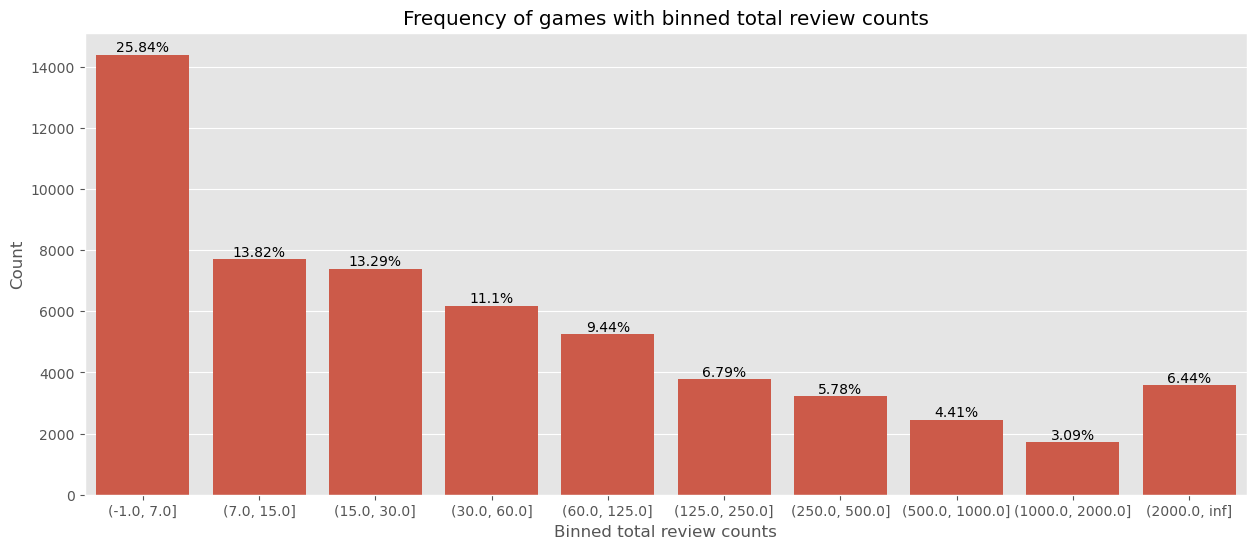

In [23]:
# Exploring the frequency of games that have over 1000 reviews
def plot_frequency_of_games_with_binned_total_review_counts() -> plt.Figure:
    fig = plt.figure(figsize=(15, 6))

    ax = sns.countplot(
        data=all_55000_steam,
        x='total_review_bins',
        # hue='total_review_bins',
    )
    values = all_55000_steam['total_review_bins'].value_counts(sort=False).values / all_55000_steam['total_review_bins'].__len__()
    values = np.round(values * 100, 2)
    values = values.astype(str)
    values = np.array([f'{v}%' for v in values])

    ax.bar_label(container=ax.containers[0], labels=values)

    plt.title('Frequency of games with binned total review counts')
    plt.xlabel('Binned total review counts')
    plt.ylabel('Count')

    return fig
fig = plot_frequency_of_games_with_binned_total_review_counts()

In [149]:
# Ratio between positive and total
# Lets find our most liked stuff!
def plot_most_liked_publishers() -> plt.Figure:
    min_total_reviews = 1000
    most_positive_publishers = all_55000_steam.groupby('publishers').agg(positive=('positive_reviews', 'sum'),
                                                                        negative=('negative_reviews', 'sum'),
                                                                        quantity=('name', 'count'))
    most_positive_publishers['total_reviews'] = most_positive_publishers['positive'] + most_positive_publishers['negative']
    most_positive_publishers['positive_ratio'] = most_positive_publishers['positive'] / most_positive_publishers['total_reviews']
    most_positive_publishers['positive_to_negative'] = most_positive_publishers['positive'] / most_positive_publishers['negative']
    most_positive_publishers = most_positive_publishers[most_positive_publishers['total_reviews'] >= min_total_reviews]
    most_positive_publishers = most_positive_publishers.sort_values(by='positive_to_negative', ascending=False)

    num_top_publishers = 20
    fig = plt.figure(figsize=(14, 7))
    sns.barplot(
        data=most_positive_publishers.head(num_top_publishers),
        x='positive_to_negative',
        y='publishers',
        hue='publishers',
        orient='h',
        dodge=False
    )
    plt.title(f"Most liked {num_top_publishers} publishers with at least {min_total_reviews} reviews")
    plt.xlabel("Positive to negative reviews ratio")
    plt.ylabel("Publishers")
    return fig
fig = plot_most_liked_publishers()

Text(0, 0.5, 'Publishers')

c:\HW\Fall_2024_MSU\CMSE830\Homework\conman\Lib\site-packages\IPython\core\events.py:82: UserWarning:

Glyph 12375 (\N{HIRAGANA LETTER SI}) missing from font(s) DejaVu Sans.

c:\HW\Fall_2024_MSU\CMSE830\Homework\conman\Lib\site-packages\IPython\core\events.py:82: UserWarning:

Glyph 12425 (\N{HIRAGANA LETTER RA}) missing from font(s) DejaVu Sans.

c:\HW\Fall_2024_MSU\CMSE830\Homework\conman\Lib\site-packages\IPython\core\events.py:82: UserWarning:

Glyph 12383 (\N{HIRAGANA LETTER TA}) missing from font(s) DejaVu Sans.

c:\HW\Fall_2024_MSU\CMSE830\Homework\conman\Lib\site-packages\IPython\core\events.py:82: UserWarning:

Glyph 12414 (\N{HIRAGANA LETTER MA}) missing from font(s) DejaVu Sans.

c:\HW\Fall_2024_MSU\CMSE830\Homework\conman\Lib\site-packages\IPython\core\events.py:82: UserWarning:

Glyph 12371 (\N{HIRAGANA LETTER KO}) missing from font(s) DejaVu Sans.

c:\HW\Fall_2024_MSU\CMSE830\Homework\conman\Lib\site-packages\IPython\core\events.py:82: UserWarning:

Glyph 26517 (\N{CJK UN

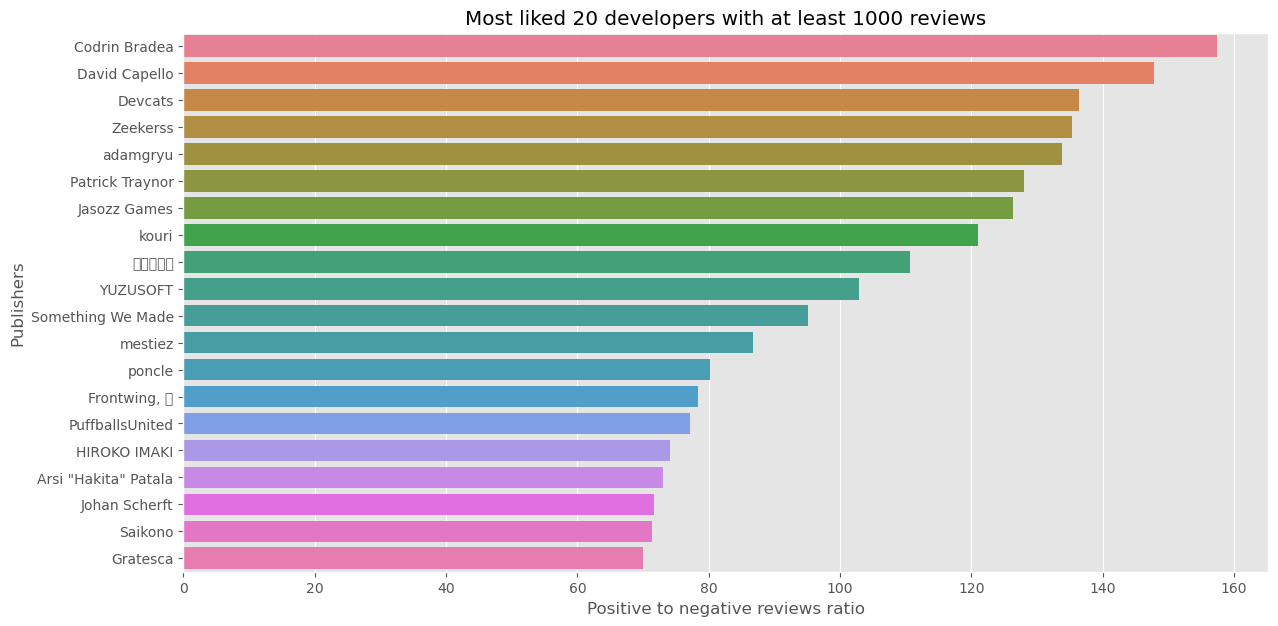

In [168]:
def plot_most_liked_developers() -> plt.Figure:
    min_total_reviews = 1000
    most_positive_developers = all_55000_steam.groupby('developers').agg(positive=('positive_reviews', 'sum'),
                                                                        negative=('negative_reviews', 'sum'),
                                                                        quantity=('name', 'count'))
    most_positive_developers['total_reviews'] = most_positive_developers['positive'] + most_positive_developers['negative']
    most_positive_developers['positive_ratio'] = most_positive_developers['positive'] / most_positive_developers['total_reviews']
    most_positive_developers['positive_to_negative'] = most_positive_developers['positive'] / most_positive_developers['negative']
    most_positive_developers = most_positive_developers[most_positive_developers['total_reviews'] >= min_total_reviews]
    most_positive_developers = most_positive_developers.sort_values(by='positive_to_negative', ascending=False)

    num_top_developers = 20
    fig = plt.figure(figsize=(14, 7))
    sns.barplot(
        data=most_positive_developers.head(num_top_developers),
        x='positive_to_negative',
        y='developers',
        hue='developers',
        orient='h',
        dodge=False
    )
    plt.title(f"Most liked {num_top_developers} developers with at least {min_total_reviews} reviews")
    plt.xlabel("Positive to negative reviews ratio")
    plt.ylabel("Publishers")
    return fig
fig = plot_most_liked_developers()

In [65]:
# By making owners a categorical ordinal, we can plot this in order of owners
def plot_most_liked_owners() -> plt.Figure:
    most_positive_owner_group = all_55000_steam.groupby('owners').agg(positive=('positive_reviews', 'sum'),
                                                                        negative=('negative_reviews', 'sum'),
                                                                        quantity=('name', 'count'))
    most_positive_owner_group['total_reviews'] = most_positive_owner_group['positive'] + most_positive_owner_group['negative']
    most_positive_owner_group['positive_ratio'] = most_positive_owner_group['positive'] / most_positive_owner_group['total_reviews']
    most_positive_owner_group['positive_to_negative'] = most_positive_owner_group['positive'] / most_positive_owner_group['negative']

    

    fig = plt.figure(figsize=(14, 7))
    sns.barplot(
        data=most_positive_owner_group,
        x='positive_to_negative',
        y='owners',
        hue='owners',
        orient='h',
        dodge=False
    )
    plt.title("Game owner estimations vs positive to negative reviews ratio")
    plt.xlabel("Positive to negative reviews ratio")
    plt.ylabel("Owner estimations")
    return fig
fig = plot_most_liked_owners()

C:\Users\jie22\AppData\Local\Temp\ipykernel_26672\2526899630.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  most_positive_owner_group = all_55000_steam.groupby('owners').agg(positive=('positive_reviews', 'sum'),


In [67]:
# Regression line

def plot_positive_and_negative_review_counts_regression():
    # Linear regression model
    X = all_55000_steam[['positive_reviews']]
    y = all_55000_steam['negative_reviews']
    model = LinearRegression().fit(X, y)
    predicted_negative_review_count = model.predict(X)

    print(model.score(X, y))

    fig = px.scatter(
        all_55000_steam,
        x="positive_reviews",
        y="negative_reviews",
        title=f"Positive vs negative review counts (m={model.coef_[0]:.4f}, b={model.intercept_:.4f})",
        labels={"positive_reviews": "Positive Review Count", "negative_reviews": "Negative Review Count"},
    )
    fig.add_traces(px.line(all_55000_steam, x="positive_reviews", y=predicted_negative_review_count).data)

    return fig
fig = plot_positive_and_negative_review_counts_regression()
fig.show()

0.6161785320840478


# Release Date

In [13]:
# By release year, lets see the trends in game review scores per year.
def plot_release_date_distribution() -> plt.Figure:
    fig = plt.figure(figsize=(12, 6))
    sns.countplot(
        data=all_55000_steam,
        y='release_year',
        orient='h',
    )
    plt.title("Game release year frequency")
    plt.xlabel("Count")
    plt.ylabel("Release year")
    return fig
fig = plot_release_date_distribution()

In [64]:
def plot_release_year_to_total_reviews() -> plt.Figure:
    fig = plt.figure(figsize=(12, 6))
    reviews_by_year = all_55000_steam.groupby("release_year")['total_review_count'].sum()
    reviews_by_year
    sns.barplot(
        x=reviews_by_year.values,
        y=reviews_by_year.index,
        orient='h',
    )
    plt.xlabel('Total review count')
    plt.ylabel('Release year')
    plt.title('Total review counts on Steam by year')
    return fig
fig = plot_release_year_to_total_reviews()

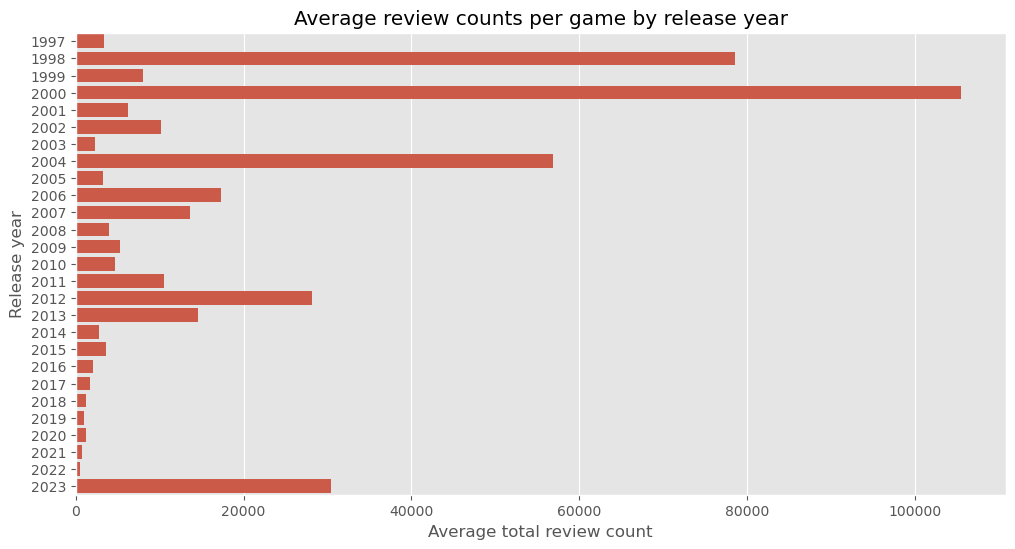

In [7]:
# How does the release year affect our review score?
def plot_release_year_to_average_total_review_count_per_game() -> plt.Figure:
    fig = plt.figure(figsize=(12, 6))
    reviews_by_year = all_55000_steam.groupby("release_year")['total_review_count'].mean()
    reviews_by_year
    sns.barplot(
        x=reviews_by_year.values,
        y=reviews_by_year.index,
        orient='h',
    )
    plt.xlabel('Average total review count')
    plt.ylabel('Release year')
    plt.title('Average review counts per game by release year')
    return fig
fig = plot_release_year_to_average_total_review_count_per_game()

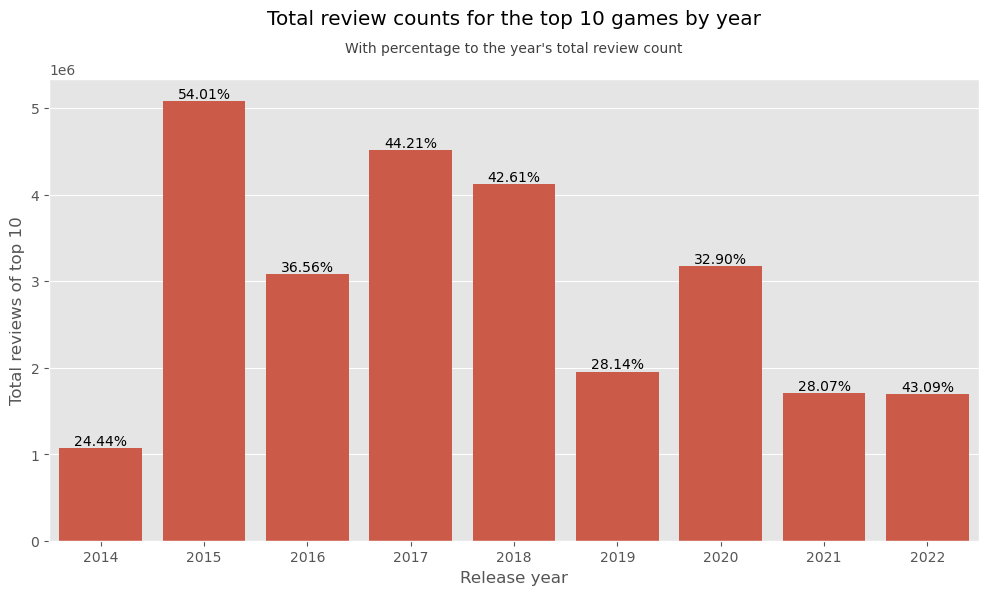

In [10]:
# Do our top dogs always seem to take the crown?
# fig = plt.figure(figsize=(12, 6))
def plot_top_10_sum_and_proportion() -> plt.Figure:
    sorted_review_count_per_year = all_55000_steam.sort_values(by='total_review_count', ascending=False)
    total_review_count_per_year = sorted_review_count_per_year.groupby("release_year")[['name', 'total_review_count']].agg({
        'name': 'count',
        'total_review_count': 'sum',
    }).rename(
        columns={'name': 'count'}
    ).reset_index()

    total_review_count_per_year = total_review_count_per_year[total_review_count_per_year['count'] > 1000]

    total_review_count_per_year_top_10 = (
        sorted_review_count_per_year.groupby("release_year")
        .head(10)
        .groupby("release_year")
        .agg({
            'total_review_count': 'sum'
        }).rename(
            columns={'total_review_count': 'total_review_count_top_10'}
        )
        .reset_index()
    )

    merged_total_and_slicesum_review_count_per_year = pd.merge(total_review_count_per_year, total_review_count_per_year_top_10, on='release_year', how='left')
    merged_total_and_slicesum_review_count_per_year[
        "proportion_of_reviews_of_top_10_to_total"
    ] = (
        merged_total_and_slicesum_review_count_per_year["total_review_count_top_10"]
        / merged_total_and_slicesum_review_count_per_year["total_review_count"]
    )
    # print(merged_total_and_slicesum_review_count_per_year)
    fig = plt.figure(figsize=(12, 6))
    ax = sns.barplot(
        data=merged_total_and_slicesum_review_count_per_year,
        x='release_year',
        y='total_review_count_top_10',
        dodge=False,
    )
    values = merged_total_and_slicesum_review_count_per_year['proportion_of_reviews_of_top_10_to_total']
    values = np.array([f'{v * 100:.2f}%' for v in values])
    ax.bar_label(container=ax.containers[0], labels=values)
    plt.title("Total review counts for the top 10 games by year", y=1.1)
    ax.text(x=0.5, y=1.05, s="With percentage to the year's total review count", fontsize=10, alpha=0.75, ha='center', va='bottom', transform=ax.transAxes)
    plt.xlabel("Release year")
    plt.ylabel("Total reviews of top 10")
    return fig
fig = plot_top_10_sum_and_proportion()
    # print(merged_total_and_slicesum_review_count_per_year['proportion_of_reviews_of_top_10_to_total'].corr(merged_total_and_slicesum_review_count_per_year['release_year']))

C:\Users\jie22\AppData\Local\Temp\ipykernel_23908\704247645.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  genre_proportions_filtered['genre_proportion'] = genre_proportions_filtered['count'] / genre_proportions_filtered['total_genres']


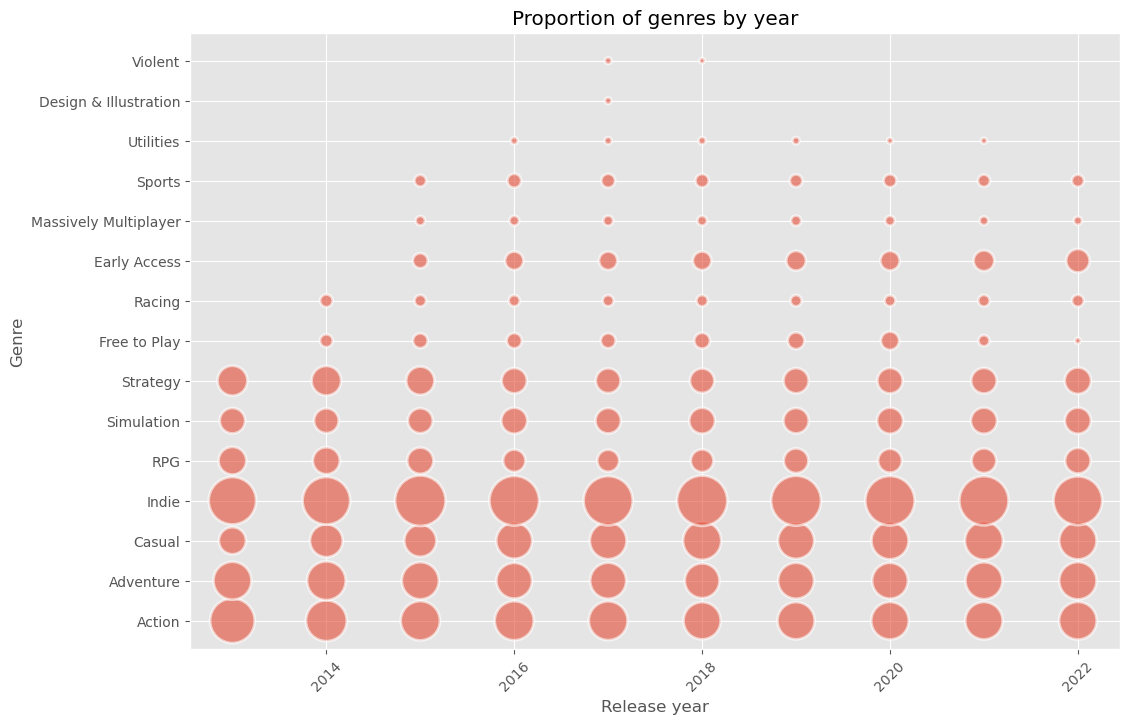

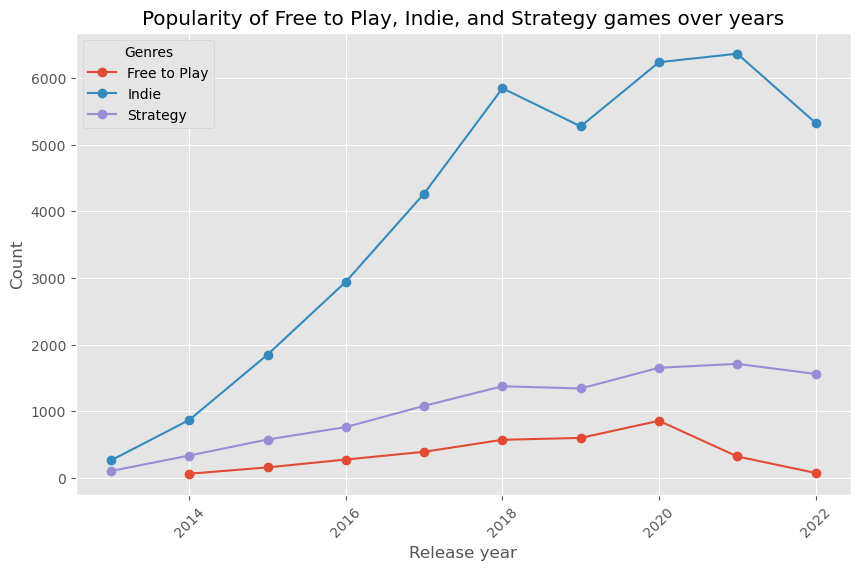

In [12]:
# How does release date correlate at all with genre?
def plot_bubble_proportions_of_genre_by_year() -> plt.Figure:
    all_55000_steam_copy = all_55000_steam.copy(deep=True)
    all_55000_steam_copy['genres'] = all_55000_steam_copy['genres'].str.split(', ')
    all_55000_steam_exploded_genres = all_55000_steam_copy.explode('genres')
    genre_counts = all_55000_steam_exploded_genres.groupby(['release_year', 'genres']).size().reset_index(name='count')
    total_genres_per_year = all_55000_steam_exploded_genres.groupby('release_year').size().reset_index(name='total_genres')
    genre_proportions = pd.merge(genre_counts, total_genres_per_year, on='release_year')

    genre_proportions_filtered = genre_proportions[(genre_proportions['total_genres'] > 1000) & 
                                                (genre_proportions['count'] >= 60)]
    genre_proportions_filtered['genre_proportion'] = genre_proportions_filtered['count'] / genre_proportions_filtered['total_genres']


    fig = plt.figure(figsize=(12, 8))
    plt.scatter(
        x = genre_proportions_filtered["release_year"],
        y = genre_proportions_filtered["genres"],
        s=genre_proportions_filtered["genre_proportion"] * 5000,  # Scaling the bubble size by proportion * number for clarity
        alpha=0.6,
        edgecolors="w",
        linewidth=2,
    )

    plt.xlabel('Release year')
    plt.ylabel('Genre')
    plt.title('Proportion of genres by year')
    plt.xticks(rotation=45)
    plt.grid(True)
    return fig
fig = plot_bubble_proportions_of_genre_by_year()

def plot_genres_of_interest_trends() -> plt.Figure:
    all_55000_steam_copy = all_55000_steam.copy(deep=True)
    all_55000_steam_copy['genres'] = all_55000_steam_copy['genres'].str.split(', ')
    all_55000_steam_exploded_genres = all_55000_steam_copy.explode('genres')
    genre_counts = all_55000_steam_exploded_genres.groupby(['release_year', 'genres']).size().reset_index(name='count')
    total_genres_per_year = all_55000_steam_exploded_genres.groupby('release_year').size().reset_index(name='total_genres')
    genre_proportions = pd.merge(genre_counts, total_genres_per_year, on='release_year')

    genre_proportions_filtered = genre_proportions[(genre_proportions['total_genres'] > 1000) & 
                                                (genre_proportions['count'] >= 60)]

    genres_of_interest = ["Free to Play", "Indie", "Strategy"]
    genre_trends = genre_proportions_filtered[genre_proportions_filtered['genres'].isin(genres_of_interest)]

    fig = plt.figure(figsize=(10, 6))

    for genre in genres_of_interest:
        genre_data = genre_trends[genre_trends['genres'] == genre]
        plt.plot(genre_data['release_year'], genre_data['count'], label=genre, marker='o')

    plt.xlabel('Release year')
    plt.ylabel('Count')
    plt.title('Popularity of Free to Play, Indie, and Strategy games over years')
    plt.xticks(rotation=45)
    plt.legend(title="Genres")
    plt.grid(True)
    return fig
fig = plot_genres_of_interest_trends()


# Genres

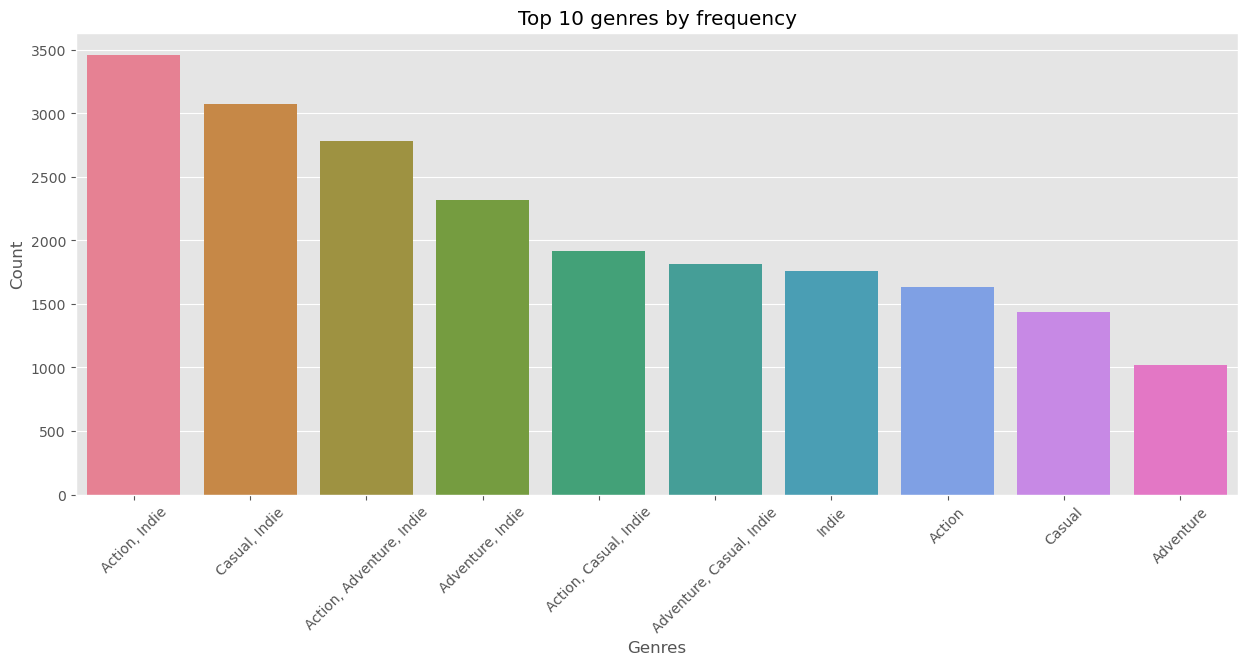

In [26]:
def plot_top_n_genres_distribution(n = 10):
    genre_frequencies = pd.DataFrame(
        {
            'genres': all_55000_steam['genres'].value_counts().index,
            'count': all_55000_steam['genres'].value_counts().values
        }
    )
    genre_frequencies
    top_genre_frequencies = genre_frequencies.head(n)

    fig = plt.figure(figsize=(15, 6))
    sns.barplot(
        data=top_genre_frequencies,
        x='genres',
        y='count',
        hue='genres',
        dodge=False,
    )
    plt.title(f"Top {n} genres by frequency")
    plt.xlabel("Genres")
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    return fig
    # return top_genre_frequences

fig = plot_top_n_genres_distribution()

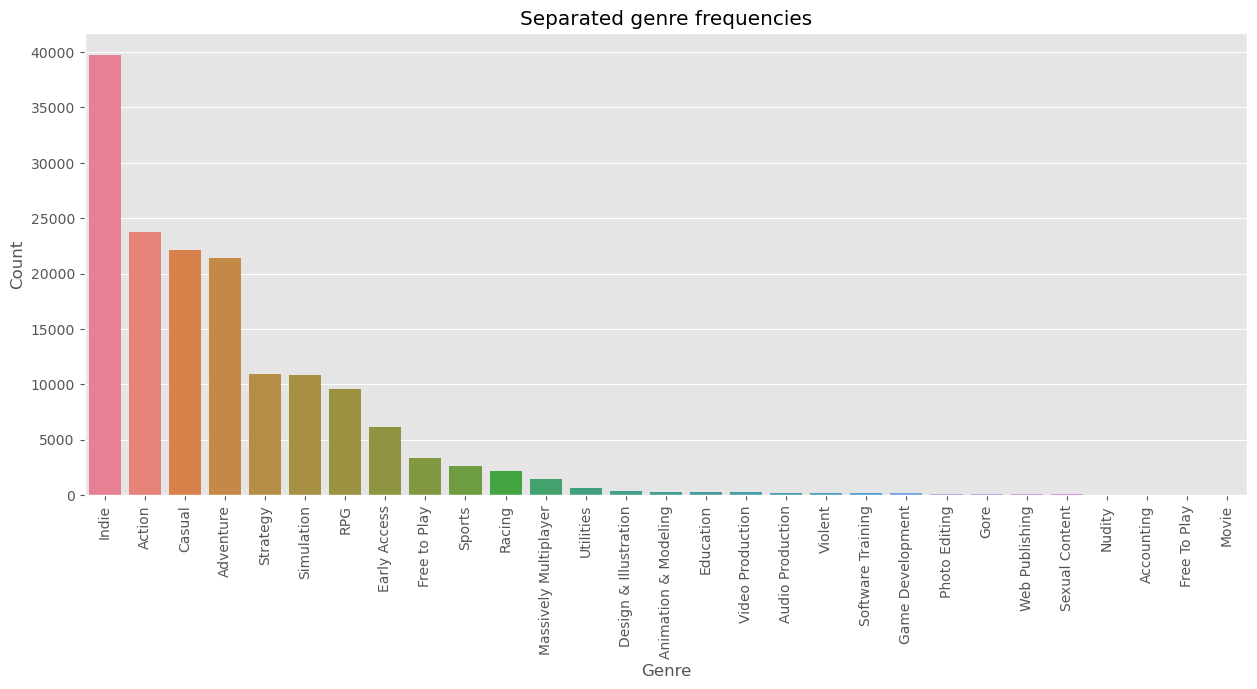

In [45]:
def plot_exploded_genre_frequencies() -> plt.Figure:
    genres_exploded = all_55000_steam['genres'].str.split(', ').explode()
    genre_counts = genres_exploded.groupby(genres_exploded).size().reset_index(name='genre_count')

    sorted_genre_counts = genre_counts.sort_values(by='genre_count', ascending=False)

    fig = plt.figure(figsize=(15, 6))
    sns.barplot(
        data = sorted_genre_counts,
        x='genres',
        y='genre_count',
        hue='genres',
        dodge=False
    )
    plt.title("Separated genre frequencies")
    plt.xticks(rotation=90)
    plt.xlabel('Genre')
    plt.ylabel('Count')
    return fig
fig = plot_exploded_genre_frequencies()

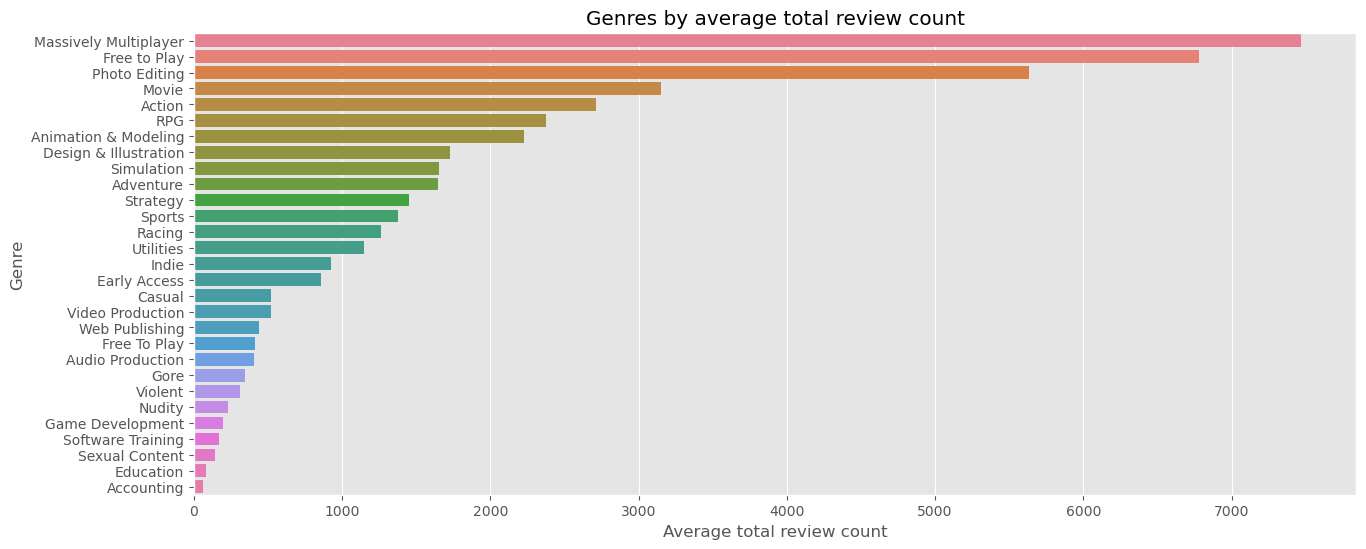

In [87]:
# Check if genre is associated with anything

# genres_exploded = all_55000_steam['genres'].str.split(', ').explode()
# genre_counts = genres_exploded.groupby(genres_exploded).size().reset_index(name='genre_count')
# sorted_genre_counts = genre_counts.sort_values(by='genre_count', ascending=False)

# genre_revenue = all_55000_steam.groupby('genres')['revenue'].mean().reset_index()

# indie_publisher_summary = pd.merge(indie_publisher_counts, indie_publisher_revenue, left_on='publishers', right_on='publishers', how='left')
# indie_publisher_summary.loc[indie_publisher_summary['revenue'].isna(), 'revenue'] = 0
# indie_publisher_summary['publishers'] = indie_publisher_summary['publishers'].astype(str)

# all_55000_steam['genres_split']
def plot_genres_combination_plots() -> plt.Figure:
    def split_genres(x):
        if type(x) is str:
            return x.split(', ')
        else:
            return x
    all_55000_steam['genres_split'] = all_55000_steam['genres'].apply(split_genres)
    all_55000_steam_genres_exploded = all_55000_steam.explode('genres_split')
    avg_revenue_by_genre = all_55000_steam_genres_exploded.groupby('genres_split')['total_review_count'].mean().reset_index()
    avg_revenue_by_genre = avg_revenue_by_genre.sort_values(by='total_review_count', ascending=False)

    fig = plt.figure(figsize=(15, 6))
    sns.barplot(
        data=avg_revenue_by_genre,
        x='total_review_count',
        y='genres_split',
        hue='genres_split',
        orient='h',
        dodge=False
    )
    plt.title("Genres by average total review count")
    plt.xlabel('Average total review count')
    plt.ylabel('Genre')


    # ----------------------------------------

    # avg_revenue_by_genre_group = all_55000_steam.groupby('genres')['total_review_count'].mean().reset_index()
    # avg_revenue_by_genre_group = avg_revenue_by_genre_group.sort_values(by='total_review_count', ascending=False)
    # genre_group_sizes = all_55000_steam.groupby('genres').size().reset_index(name='genre_count')
    # avg_revenue_by_genre_group_with_freq = pd.merge(avg_revenue_by_genre_group, genre_group_sizes, how='left', on='genres')

    # fig, ax1 = plt.subplots(figsize=(15, 6))

    # sns.barplot(
    #     data=avg_revenue_by_genre_group_with_freq.head(20),
    #     x='total_review_count',
    #     y='genres',
    #     color='blue',
    #     ax=ax1
    # )
    # ax1.set_xlabel('Average Total Review Count')
    # ax1.set_ylabel('Genre Combinations')
    # ax1.set_title("Top 20 Genre Combinations by Average Total Review Count with Frequencies")

    # # twin axis for frequencies
    # ax2 = ax1.twiny()
    # sns.barplot(
    #     data=avg_revenue_by_genre_group_with_freq.head(20),
    #     x='genre_count',
    #     y='genres',
    #     color='green',
    #     ax=ax2
    # )
    # ax2.set_xlabel('Genre Count')

    # ----------------------------------------

    # fig_2 = plt.figure(figsize=(15, 6))
    # sns.barplot(
    #     data=avg_revenue_by_genre_group.head(20),
    #     x='total_review_count',
    #     y='genres',
    #     hue='genres',
    #     orient='h',
    #     dodge=False
    # )
    # plt.title(f"Top {20} genre combinations by average total review count")
    # plt.xlabel('Average total review count')
    # plt.ylabel('Genre combination')

    # genre_group_sizes = all_55000_steam.groupby('genres').size().reset_index(name='genre_count')
    # avg_revenue_by_genre_group_with_freq = pd.merge(avg_revenue_by_genre_group, genre_group_sizes, how='left', on='genres')

    # fig_3 = plt.figure(figsize=(15, 6))
    # sns.barplot(
    #     data=avg_revenue_by_genre_group_with_freq.head(20),
    #     x='genre_count',
    #     y='genres',
    #     hue='genres',
    #     orient='h',
    #     dodge=False
    # )
    # plt.title(f"Top {20} genre combinations by average total review count: frequencies")
    # plt.xlabel('Count')
    # plt.ylabel('Genre combination')
    # return fig_1, fig_2, fig_3
fig = plot_genres_combination_plots()

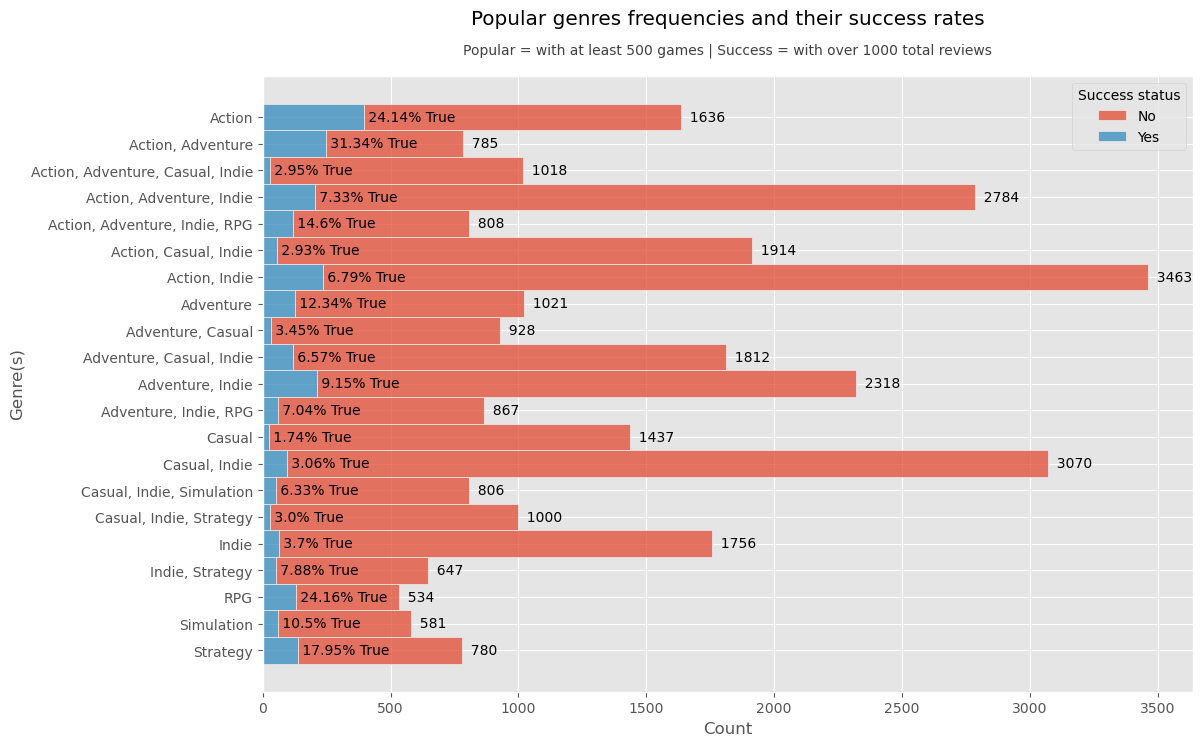

In [100]:
# Plotting genre against total_review_count
# Get genres list with at least 500 different games of the same genre
# Then lets see, how many of those games in those genres have over 1000 reviews, how many have less than 1000 reviews? Are there any games within those genres that have a high rate of success? What is the comparison?

def plot_genre_frequencies_with_success_rate() -> plt.Figure:
    n = 500
    genre_group_sizes = all_55000_steam.groupby('genres').size().reset_index(name='genre_count')
    genre_total_reviews = all_55000_steam.groupby('genres')['total_review_count'].median().reset_index(name='average_total_review_count')
    genres_with_at_least_n_games = genre_group_sizes[genre_group_sizes['genre_count'] >= 500]['genres'].tolist()
    # print(genres_with_at_least_n_games.__len__())

    all_55000_steam_within_genre_list = all_55000_steam[all_55000_steam['genres'].isin(genres_with_at_least_n_games)]
    all_55000_steam_within_genre_list = pd.merge(all_55000_steam_within_genre_list, genre_total_reviews, on='genres', how='left')
    all_55000_steam_within_genre_list['over_1000_total_reviews'] = all_55000_steam_within_genre_list['total_review_count'] > 1000
    all_55000_steam_within_genre_list = all_55000_steam_within_genre_list.sort_values(by='genres')

    stacked_data = all_55000_steam_within_genre_list.groupby(['genres', 'over_1000_total_reviews']).size().unstack()
    stacked_data['total_count'] = stacked_data.sum(axis=1)
    stacked_data = stacked_data.reset_index()
    stacked_data.index.name = None
    stacked_data['percentage_successful'] = (stacked_data[True] / stacked_data['total_count']) * 100
    stacked_data['percentage_successful'] = stacked_data['percentage_successful'].round(2)

    plt.figure(figsize=(12, 8))

    ax = sns.histplot(
        data=all_55000_steam_within_genre_list,
        y='genres',
        hue='over_1000_total_reviews',
        multiple='stack',
    )

    ax.bar_label(ax.containers[0], labels=[" " + str(x) + '% True' for x in stacked_data['percentage_successful']])
    ax.bar_label(ax.containers[1], labels=["  " + str(x) for x in stacked_data['total_count']])
    ax.legend_.set_title("Success status")
    for text, label in zip(ax.legend_.texts, ['No', 'Yes']):
        text.set_text(label)
    plt.title("Popular genres frequencies and their success rates", y=1.07)
    ax.text(x=0.5, y=1.03, s=f"Popular = with at least {n} games | Success = with over 1000 total reviews", fontsize=10, alpha=0.75, ha='center', va='bottom', transform=ax.transAxes)
    plt.xlabel("Count")
    plt.ylabel("Genre(s)")
fig = plot_genre_frequencies_with_success_rate()

# display(all_55000_steam_within_genre_list[['name', 'genres', 'owners', 'average_total_review_count', 'total_review_count', 'over_1000_total_reviews']])
# all_55000_steam_within_genre_list
# plt.figure(figsize=(12, 6))
# sns.scatterplot(
#     data = all_55000_steam_within_genre_list,
#     x = 'total_review_count',
#     y = 'genres',
#     hue = 'owners',
# )

# Dashboard

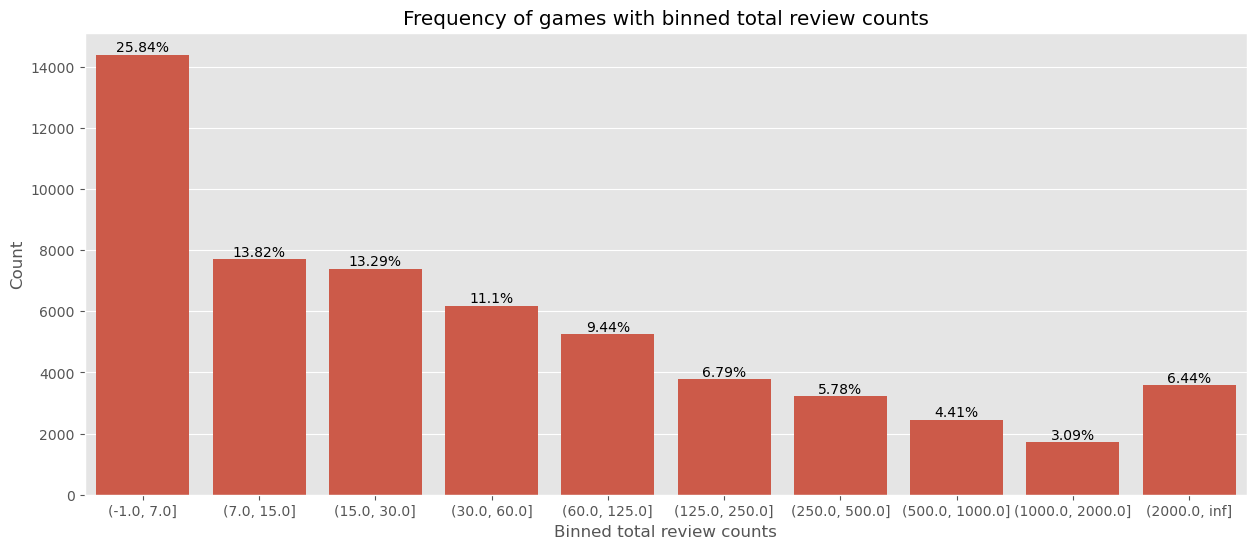

In [36]:
# Exploring the frequency of games that have over 1000 reviews
def plot_frequency_of_games_with_binned_total_review_counts() -> plt.Figure:
    fig = plt.figure(figsize=(15, 6))

    ax = sns.countplot(
        data=all_55000_steam,
        x='total_review_bins',
    )
    values = all_55000_steam['total_review_bins'].value_counts(sort=False).values / all_55000_steam['total_review_bins'].__len__()
    values = np.round(values * 100, 2)
    values = values.astype(str)
    values = np.array([f'{v}%' for v in values])

    ax.bar_label(container=ax.containers[0], labels=values)

    plt.title('Frequency of games with binned total review counts')
    plt.xlabel('Binned total review counts')
    plt.ylabel('Count')

    return fig
fig = plot_frequency_of_games_with_binned_total_review_counts()


In [41]:
pick_from_genre_list = ['MassivelyMultiplayer', 'Early Access', 'Racing', 'Free to Play', 'Strategy', 'RPG', 'Indie', 'Casual', 'Adventure', 'Action']

def plot_genres_of_interest_trends_plotly(genres_of_interest: list[str] = ["Free to Play", "Indie", "Strategy"]):
    all_55000_steam_copy = all_55000_steam.copy(deep=True)
    all_55000_steam_copy['genres'] = all_55000_steam_copy['genres'].str.split(', ')
    all_55000_steam_exploded_genres = all_55000_steam_copy.explode('genres')
    
    
    genre_counts = all_55000_steam_exploded_genres.groupby(['release_year', 'genres']).size().reset_index(name='count')
    total_genres_per_year = all_55000_steam_exploded_genres.groupby('release_year').size().reset_index(name='total_genres')
    
    
    genre_proportions = pd.merge(genre_counts, total_genres_per_year, on='release_year')
    
    
    genre_proportions_filtered = genre_proportions[(genre_proportions['total_genres'] > 1000) & 
                                                   (genre_proportions['count'] >= 60)]
    
    
    genre_trends = genre_proportions_filtered[genre_proportions_filtered['genres'].isin(genres_of_interest)]
    colors = pc.qualitative.Plotly
    
    fig = px.line(
        genre_trends,
        x='release_year',
        y='count',
        color='genres',
        title='Popularity of Free to Play, Indie, and Strategy Games Over Years',
        labels={'count': 'Count', 'release_year': 'Release Year'},
        markers=True,
        color_discrete_sequence=colors
    )

    fig.update_layout(
        xaxis_title='Release Year',
        yaxis_title='Count',
        legend_title_text='Genres',
        width=900,
        height=600,
    )
    
    return fig

fig = plot_genres_of_interest_trends_plotly()
fig.show()

In [131]:
def dashboard_plot_genre_frequencies_and_success_status(n: int = 500) -> go.Figure:
    genre_group_sizes = all_55000_steam.groupby('genres').size().reset_index(name='genre_count')
    genre_total_reviews = all_55000_steam.groupby('genres')['total_review_count'].median().reset_index(name='average_total_review_count')
    genres_with_at_least_n_games = genre_group_sizes[genre_group_sizes['genre_count'] >= n]['genres'].tolist()
    # print(genres_with_at_least_n_games.__len__())

    all_55000_steam_within_genre_list = all_55000_steam[all_55000_steam['genres'].isin(genres_with_at_least_n_games)]
    all_55000_steam_within_genre_list = pd.merge(all_55000_steam_within_genre_list, genre_total_reviews, on='genres', how='left')
    all_55000_steam_within_genre_list['over_1000_total_reviews'] = all_55000_steam_within_genre_list['total_review_count'] > 1000
    all_55000_steam_within_genre_list = all_55000_steam_within_genre_list.sort_values(by='genres')

    stacked_data = all_55000_steam_within_genre_list.groupby(['genres', 'over_1000_total_reviews']).size().unstack()
    stacked_data['total_count'] = stacked_data.sum(axis=1)
    stacked_data = stacked_data.reset_index()
    stacked_data.index.name = None
    stacked_data['percentage_successful'] = (stacked_data[True] / stacked_data['total_count']) * 100
    stacked_data['percentage_successful'] = stacked_data['percentage_successful'].round(2)

    colors = pc.qualitative.Plotly

    fig = px.histogram(
            all_55000_steam_within_genre_list,
            y='genres',
            color='over_1000_total_reviews',
            barmode='stack',
            histfunc='count',
            labels={'over_1000_total_reviews': 'Success status', 'genres': 'Genres'},
            color_discrete_map={True: colors[0], False: colors[1]} 
        )

    success_status_name_changes = {
        'True': 'Yes',
        'False': 'No',
    }
    fig.for_each_trace(lambda t: t.update(name = success_status_name_changes[str(t.name)],
                                        legendgroup = success_status_name_changes[str(t.name)],
                                        hovertemplate = t.hovertemplate.replace(str(t.name), success_status_name_changes[str(t.name)])
                                        )
    )

    # Hacky way to add annotations to the bars, since I have a 'stack' mode histogram, I can just add a 'transparent bar' to each in same order with text.
    for i, row in stacked_data.iterrows():
        fig.add_trace(go.Bar(
            y=[row['genres']],
            x=[10] * len(stacked_data), # Text spacing of 10 count
            orientation='h',
            showlegend=False,
            text=f"{row['percentage_successful']}%",
            textfont_size=15,
            marker_color='rgba(0,0,0,0)',  # Hide bar
            hoverinfo='skip'
        ))

    fig.update_layout(
        yaxis_title="Genres",
        xaxis_title="Count",
        legend_title="Success status",
        bargap=0.2,
        height=800,
        showlegend=True,
        margin=dict(l=200, r=50, t=80, b=50),
        title=go.layout.Title(
            text=f"Popular genres frequencies and their success rates<br><sup>Popular = with at least {n} games | Success = with over 1000 total reviews</sup>"
        )
    )
    return fig
fig = dashboard_plot_genre_frequencies_and_success_status()
fig.show()